In [11]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random
from task_1c_v2 import cvr_op_scheme, cvr_tp_scheme

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4


In [12]:
# Load data
with open('Data/ALL_scenarios.json') as f:
    all_scenarios = json.load(f)

# Constants
OMEGA = 250  # Number of scenarios to sample
PI = 1 / OMEGA  # Probability of each sampled scenario - assumed to be equal
S = len(all_scenarios.keys()) - 1  # Total number of scenarios
T = 24  # Number of hours
WIND_CAPACITY = 200  # MWh

random.seed(123)

# Sample scenarios without replacement
in_sample_scenarios = random.sample(range(S), 250)

scenarios = {}

# Extract sampled scenarios from dictionary containing all scenarios
for i in range(len(in_sample_scenarios)):
    scenarios[str(i)] = all_scenarios[str(in_sample_scenarios[i])]
    scenarios[str(i)]['Original Index'] = in_sample_scenarios[i]

# Indices of all scenarios
all_indices = list(range(S))



In [55]:
alpha = 0.9
beta_values = [0.5] #np.arange(0, 1, 0.25)

In [56]:
# One-price
# Initialize lists to store results
out_sample_profits = []
expected_values = []

num_scenarios = [170, 250, 360, 430, 540]

for OMEGA in num_scenarios:
    in_sample_scenarios = random.sample(range(len(all_scenarios.keys()) - 1), OMEGA)
    
    scenarios = {}
    for i, idx in enumerate(in_sample_scenarios):
        scenarios[str(i)] = all_scenarios[str(idx)]
        scenarios[str(i)]['Original Index'] = idx
    
    # Indices of out-of-sample scenarios
    out_of_sample_indices = list(set(all_indices) - set(in_sample_scenarios))

    # Sample 950 out-of-sample scenarios without replacement
    out_sample_indices = random.sample(out_of_sample_indices, 950)
    print(out_sample_indices)


    # Extract out-of-sample scenarios from the dictionary containing all scenarios
    out_sample_scenarios = {}
    for i, idx in enumerate(out_sample_indices):
        out_sample_scenarios[str(i)] = all_scenarios[str(idx)]
        out_sample_scenarios[str(i)]['Original Index'] = idx

    # Run optimization for one-price
    results_per_beta_op, p_DA_values_per_beta_op = cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values, minimize_printouts=False, mip_gap = 1e-4) 
    beta_val = 0.5
    optimal_DA_oneprice = np.array(p_DA_values_per_beta_op[beta_val])
    expected_profit = results_per_beta_op[beta_val]['Expected Profit']

    out_sample_earnings = 0

    for scenario_idx in out_sample_scenarios:
        scenario = out_sample_scenarios[scenario_idx]

        x = scenario['Spot Price [EUR/MWh]'] * optimal_DA_oneprice

        realized_imbalance = np.array(scenario['Wind Power [MW]']) - optimal_DA_oneprice

        price_coefficient = 1.2 * np.array(scenario['System Balance State']) + 0.9 * (1 - np.array(scenario['System Balance State']))
        y = realized_imbalance * price_coefficient * scenario['Spot Price [EUR/MWh]']

        payment_earnings = x + y
        
        out_sample_earnings += np.sum(payment_earnings)

    # Calculate average payment or earnings over out-of-sample scenarios
    average_out_sample_profits = out_sample_earnings / len(out_sample_scenarios)
    out_sample_profits.append(average_out_sample_profits)

    expected_values.append(expected_profit)
        
    print(f"Number of scenarios {OMEGA}  in-sample profits: {expected_profit}, out-sample profits: {average_out_sample_profits}")


[329, 1428, 627, 1931, 1605, 328, 1823, 1510, 1793, 1545, 891, 1994, 1598, 1711, 715, 289, 1972, 975, 998, 353, 1796, 756, 573, 1437, 652, 1059, 1213, 310, 1767, 222, 839, 1760, 352, 23, 1052, 1182, 69, 313, 102, 885, 223, 1333, 285, 1381, 1607, 169, 1421, 110, 910, 1687, 1206, 602, 87, 476, 187, 1087, 617, 782, 1348, 292, 649, 260, 183, 1623, 1008, 1868, 587, 1271, 1781, 408, 1214, 787, 1629, 989, 492, 445, 1467, 796, 699, 964, 576, 1400, 1588, 1724, 1922, 205, 35, 1359, 266, 614, 394, 1700, 1876, 1472, 626, 125, 96, 397, 660, 1388, 1056, 1196, 1536, 229, 1407, 190, 1993, 463, 778, 1062, 90, 255, 823, 815, 961, 890, 207, 33, 1363, 42, 467, 623, 216, 1027, 1114, 202, 1064, 1455, 1480, 577, 847, 209, 1174, 226, 175, 1813, 337, 944, 854, 677, 1496, 345, 877, 610, 955, 945, 440, 105, 1142, 1500, 1543, 368, 1382, 1677, 67, 1494, 593, 883, 604, 444, 129, 431, 1901, 1684, 1902, 761, 838, 1433, 1043, 1555, 302, 1761, 163, 49, 1385, 1600, 540, 870, 1395, 860, 1632, 835, 48, 1495, 1998, 689, 12

out-sample [176810.75774269894, 182020.69211751586, 176242.9466453747, 183623.74767812644, 181740.1316045331]
In-sample [191034.81578679473, 186424.88267904127, 175726.10614156877, 176589.50032384353, 179395.40342683447]


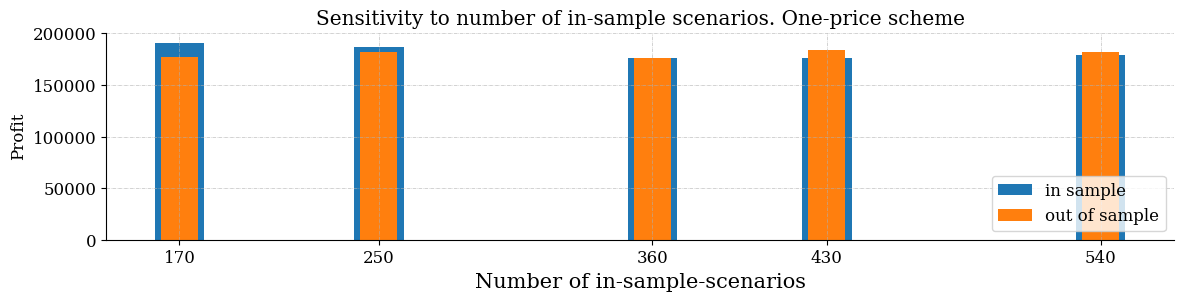

In [60]:
print(f"out-sample {out_sample_profits}")
print(f"In-sample {expected_values}")

fig = plt.figure(figsize=(12, 3))
fig.gca()

plt.bar(num_scenarios, expected_values,    width=20, label='in sample')
plt.bar(num_scenarios, out_sample_profits, width=15, label='out of sample')
plt.legend(loc = 'lower right')
plt.xticks(num_scenarios)
plt.xlabel('Number of in-sample-scenarios', size = 15)
plt.ylabel('Profit')
plt.tight_layout()
plt.title('Sensitivity to number of in-sample scenarios. One-price scheme')
plt.show()




In [58]:
# two-price
out_sample_profits_tp = []
expected_values_tp = []

num_scenarios = [170, 250, 360, 430, 540]

# Sample in-sample scenarios without replacement
for OMEGA in num_scenarios:
    in_sample_scenarios = random.sample(range(len(all_scenarios.keys()) - 1), OMEGA)
    
    scenarios = {}
    for i, idx in enumerate(in_sample_scenarios):
        scenarios[str(i)] = all_scenarios[str(idx)]
        scenarios[str(i)]['Original Index'] = idx
    
    # Indices of out-of-sample scenarios
    out_of_sample_indices = list(set(all_indices) - set(in_sample_scenarios))

    # Sample 950 out-of-sample scenarios without replacement
    out_sample_indices = random.sample(out_of_sample_indices, 950)

    # Extract out-of-sample scenarios from the dictionary containing all scenarios
    out_sample_scenarios = {}
    for i, idx in enumerate(out_sample_indices):
        out_sample_scenarios[str(i)] = all_scenarios[str(idx)]
        out_sample_scenarios[str(i)]['Original Index'] = idx

    # Run optimization for one-price
    results_per_beta_tp, p_DA_values_per_beta_tp = cvr_tp_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values, minimize_printouts=False, mip_gap = 1e-4) 
    beta_val = 0.5
    optimal_DA_twoprice = np.array(p_DA_values_per_beta_tp[beta_val])
    expected_profit = results_per_beta_tp[beta_val]['Expected Profit']

    out_sample_earnings_tp = 0

    for scenario_idx in out_sample_scenarios:
        scenario = out_sample_scenarios[scenario_idx]

        x = scenario['Spot Price [EUR/MWh]'] * optimal_DA_twoprice

        realized_imbalance = np.array(scenario['Wind Power [MW]']) - optimal_DA_twoprice

        price_coefficients = np.zeros(T)

        for t in range(T):
            if (realized_imbalance[t] > 0) and (scenario['System Balance State'][t] == 0):
                price_coefficients[t] = 0.9
            elif (realized_imbalance[t] > 0) and (scenario['System Balance State'][t] == 1):
                price_coefficients[t] = 1.0
            elif (realized_imbalance[t] < 0) and (scenario['System Balance State'][t] == 0):
                price_coefficients[t] = -1.0
            elif (realized_imbalance[t] < 0) and (scenario['System Balance State'][t] == 1):
                price_coefficients[t] = -1.2

        y = np.abs(realized_imbalance) * price_coefficients * scenario['Spot Price [EUR/MWh]']

        payment_earnings_tp = x + y

        out_sample_earnings_tp += np.sum(payment_earnings_tp)

    # Calculate average payment or earnings over out-of-sample scenarios
    average_out_sample_profits_tp = out_sample_earnings_tp / len(out_sample_scenarios)
    out_sample_profits_tp.append(average_out_sample_profits_tp)

    expected_values_tp.append(expected_profit)
        
    print(f"Number of scenarios {OMEGA}  in-sample profits function: {expected_profit}, out-sample profits: {average_out_sample_profits_tp}")

Solving for beta = 0.50...
-----------------------------------------------
Objective value: 82836.47 EUR
Expected Profit: 150978.18 EUR
CVaR: 14694.7529207821 EUR
VaR: 20377.94 EUR
Eta values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6463.45072152685, 0.0, 0.0, 10635.581365637889, 10095.554455901738, 0.0, 2158.703780832934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5582.584145304676, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1699.642604224709, 0.0, 0.0, 1984.6398646675025, 0.0, 0.0, 12905.76557020363, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3460.609989295544, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12745.895383643812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7771.176623739208, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3721.001508644742, 9456.99441578949, 4345.0952530

Number of scenarios 540  in-sample profits function: 161847.37628688486, out-sample profits: 166935.82786422616
out-sample [167419.89068526478, 162324.65396363699, 161557.3563444238, 162792.2272485554, 166935.82786422616]
In-sample [150978.18394923775, 163967.98706967363, 164096.53405980984, 167794.68481489303, 161847.37628688486]


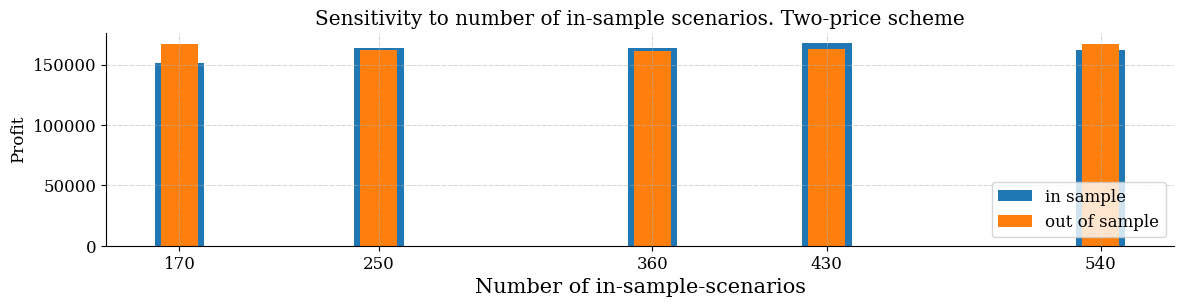

In [59]:
print(f"Number of scenarios {OMEGA}  in-sample profits function: {expected_profit}, out-sample profits: {average_out_sample_profits_tp}")

print(f"out-sample {out_sample_profits_tp}")
print(f"In-sample {expected_values_tp}")

fig = plt.figure(figsize=(12, 3))
fig.gca()

plt.bar(num_scenarios, expected_values_tp,    width=20, label='in sample')
plt.bar(num_scenarios, out_sample_profits_tp, width=15, label='out of sample')
plt.legend(loc = 'lower right')
plt.xticks(num_scenarios)
plt.xlabel('Number of in-sample-scenarios', size = 15)
plt.ylabel('Profit')
plt.tight_layout()
plt.title('Sensitivity to number of in-sample scenarios. Two-price scheme')
plt.show()
